# Chapter 7 Multivariate Time Series Modeling

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

In [40]:
df_model = pd.merge(df_share, df_average, on=['time', 'year', 'quarter'], how='left')

df_model['year_date'] = pd.to_datetime(df_model['year'].astype(str) + '-12-31')
df_electricity_price['effective_date'] = pd.to_datetime(df_electricity_price['effective_date'])
df_model = pd.merge_asof(
    df_model, df_electricity_price[['effective_date', 'tariff(sen/kWh)']],
    left_on='year_date', right_on='effective_date', direction='backward'
)
df_model.rename(columns={'tariff(sen/kWh)': 'electric_price'}, inplace=True)
df_model.drop(columns=['year_date', 'effective_date'], inplace=True)

policy_years = set(df_policy['year'])
df_model['policy'] = df_model['year'].apply(lambda x: 1 if x in policy_years else 0)

df_model.to_csv('Data/data_merged_modeling.csv', index=False)
pd.set_option('display.expand_frame_repr', False)
print(df_model.head(8))


      time  year quarter  petrol  greendiesel  hybrid_petrol  electric   total  petrol_share  greendiesel_share  hybrid_petrol_share  electric_share  ron95  ron97  diesel  diesel_eastmsia  electric_price  policy
0  2017 Q1  2017      Q1  130462        11323           1845         9  143639      0.908263           0.078830             0.012845        0.000063   2.13   2.41    2.11             2.11           38.53       0
1  2017 Q2  2017      Q2  132040        11615           1621        13  145289      0.908809           0.079944             0.011157        0.000089   2.09   2.36    2.02             2.02           38.53       0
2  2017 Q3  2017      Q3  127712        11177           2175         2  141066      0.905335           0.079232             0.015418        0.000014   2.10   2.37    2.03             2.03           38.53       0
3  2017 Q4  2017      Q4  132674        13448           3502         1  149625      0.886710           0.089878             0.023405        0.000007   2

In [41]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VECM
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.eval_measures import rmse, meanabs
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

### Vector Autoregression with Exogenous Variables Model, VARX Model

In [42]:
# Load the dataset
df_model = pd.read_csv('Data/data_merged_modeling.csv')

# Conversion time to standard form
df_model['date'] = df_model['time'].apply(
    lambda x: pd.to_datetime(f"{x.split(' ')[0]}-{ {1:1, 2:4, 3:7, 4:10}[int(x.split(' ')[1][1])]}-01")
)
df_model = df_model.set_index('date').asfreq('QS')
df_model.tail()

,time,year,quarter,petrol,greendiesel,hybrid_petrol,electric,total,petrol_share,greendiesel_share,hybrid_petrol_share,electric_share,ron95,ron97,diesel,diesel_eastmsia,electric_price,policy
date,,,,,,,,,,,,,,,,,,
2024-01-01,2024 Q1,2024,Q1,186967,14340,6192,4689,212188,0.881138,0.067582,0.029182,0.022098,2.05,3.47,2.15,2.15,45.62,1
2024-04-01,2024 Q2,2024,Q2,174267,12865,5530,5974,198636,0.877318,0.064767,0.027840,0.030075,2.05,3.47,2.49,2.15,45.62,1
2024-07-01,2024 Q3,2024,Q3,190533,12741,5729,5171,214174,0.889618,0.059489,0.026749,0.024144,2.05,3.40,3.21,2.15,45.62,1
2024-10-01,2024 Q4,2024,Q4,202793,15470,7072,5955,231290,0.876791,0.066886,0.030576,0.025747,2.05,3.20,2.95,2.15,45.62,1
2025-01-01,2025 Q1,2025,Q1,174541,9877,7130,6827,198375,0.879854,0.049790,0.035942,0.034415,2.05,3.37,3.11,2.15,45.62,1


In [43]:
# Define endogenous and exogenous variables
endog_vars = ['petrol_share', 'greendiesel_share', 'hybrid_petrol_share', 'electric_share']
exog_vars = ['ron95','ron97', 'diesel', 'diesel_eastmsia', 'electric_price', 'policy']

# Set the proportion of data to use for training and testing
n_total = len(df_model)
n_train = int(n_total * 0.9)
n_test = n_total - n_train

# Extract training and testing datasets
df_train = df_model.iloc[:n_train]
df_test = df_model.iloc[n_train:]

# Display the lengths of the datasets
print(f"The length of the total dataset: {n_total}")
print(f"The length of the training dataset: {n_train}")
print(f"The length of the testing dataset: {n_test}")

The length of the total dataset: 33
The length of the training dataset: 29
The length of the testing dataset: 4


In [44]:
# Choose the best lag order for the VAR model by human judgment
best_lag_order = 3

# Fit the VAR model with the selected lag order
model_varx_fitted = VAR(
    df_train[endog_vars],
    exog=df_train[exog_vars]
).fit(best_lag_order)
print(model_varx_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Jun, 2025
Time:                     21:10:27
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -72.2454
Nobs:                     26.0000    HQIC:                  -74.8639
Log likelihood:           915.428    FPE:                5.25532e-33
AIC:                     -75.9229    Det(Omega_mle):     5.70316e-34
--------------------------------------------------------------------
Results for equation petrol_share
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.067538              NAN              NAN             NAN
ron95                         -0.080632         0.103295           -0.781           0.435
ron97            

c:\Users\zeyu10\anaconda3\Lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1558: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


In [45]:
# Set test data for forecasting
exog_forecast = df_test[exog_vars].values
n_forecast_steps = len(df_test)

# Use the fitted model to forecast values
forecast_output = model_varx_fitted.forecast(
    y=df_train[endog_vars].values,
    steps=n_forecast_steps,
    exog_future=exog_forecast
)
df_forecast = pd.DataFrame(forecast_output, index=df_test.index, columns=endog_vars)
df_forecast

,petrol_share,greendiesel_share,hybrid_petrol_share,electric_share
date,,,,
2024-04-01,0.881613,0.044983,0.030885,0.042518
2024-07-01,0.907572,0.037371,0.021475,0.033582
2024-10-01,0.891690,0.002359,0.034313,0.071638
2025-01-01,0.900832,0.010728,0.040332,0.048108


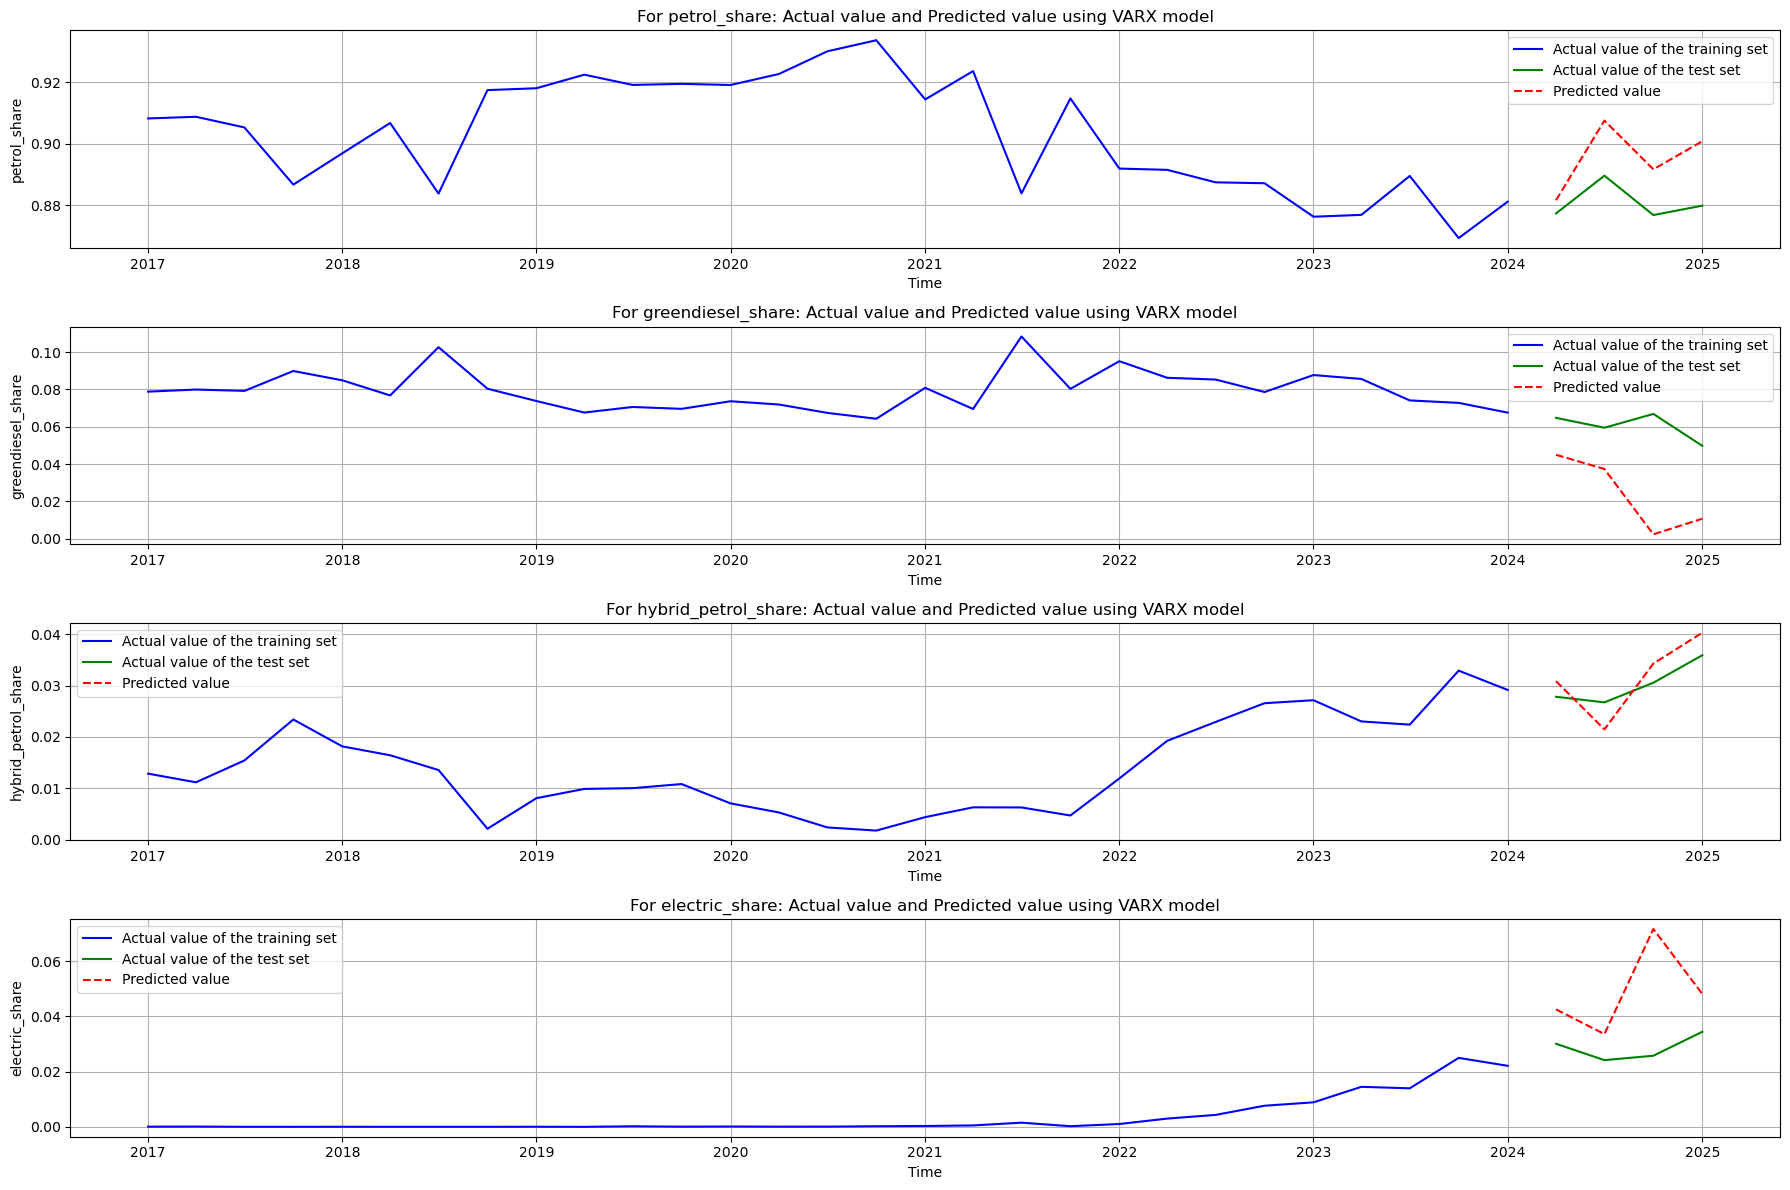

In [ ]:
# Visualize the actual values and forecasted values
plt.figure(figsize=(18, 12))
for i, var in enumerate(endog_vars):
    plt.subplot(len(endog_vars), 1, i + 1)
    plt.plot(df_train.index, df_train[var], label='Actual value of the training set', color='blue')
    plt.plot(df_test.index, df_test[var], label='Actual value of the test set', color='green')
    plt.plot(df_forecast.index, df_forecast[var], label='Predicted value', color='red', linestyle='--')
    plt.title(f'For {var}: Actual value and Predicted value using VARX model')
    plt.xlabel('Time')
    plt.ylabel(var)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# Save evaluation results
evaluation_results = []

# Evaluate the model using RMSE and MAE
for var in endog_vars: 
    actual = df_test[var]
    predicted = df_forecast[var]
    rmse_val = rmse(actual, predicted)
    mae_val = meanabs(actual, predicted)
    evaluation_results.append({
        'variable': var,
        'RMSE': rmse_val,
        'MAE': mae_val
    })

# Convert evaluation results to DataFrame
df_model_evaluation = pd.DataFrame(evaluation_results)
df_model_evaluation.to_csv('Data/data_model_VARX_evaluation_results.csv', index=False)
df_model_evaluation


,variable,RMSE,MAE
0,petrol_share,0.015834,0.014531
1,greendiesel_share,0.040528,0.036372
2,hybrid_petrol_share,0.004193,0.004112
3,electric_share,0.025186,0.020366


In [48]:
# Extended forecast to 2025 Q4
forecast_dates = pd.date_range(start='2025-04-01', end='2025-10-01', freq='QS')
n_extended_steps = len(forecast_dates)

# Fill future exog with last quarter's exog value (conservative estimate)
last_exog = df_model[exog_vars].iloc[-1]
future_exog = pd.DataFrame([last_exog.values] * n_extended_steps, columns=exog_vars, index=forecast_dates)

# Perform predictions using fitted VARX model
forecast_output_ext = model_varx_fitted.forecast(
    y=df_model[endog_vars].values[-best_lag_order:],
    steps=n_extended_steps,
    exog_future=future_exog.values
)

# Generate prediction DataFrame
df_forecast_ext = pd.DataFrame(forecast_output_ext, index=forecast_dates, columns=endog_vars)
df_full_forecast = pd.concat([df_forecast, df_forecast_ext])
df_full_forecast.to_csv('Data/data_model_VARX_full_forecast.csv', index=True)
df_full_forecast



,petrol_share,greendiesel_share,hybrid_petrol_share,electric_share
2024-04-01,0.881613,0.044983,0.030885,0.042518
2024-07-01,0.907572,0.037371,0.021475,0.033582
2024-10-01,0.891690,0.002359,0.034313,0.071638
2025-01-01,0.900832,0.010728,0.040332,0.048108
2025-04-01,0.879370,0.052386,0.028063,0.040181
2025-07-01,0.901964,0.014711,0.027496,0.055828
2025-10-01,0.889539,0.009212,0.038709,0.062540


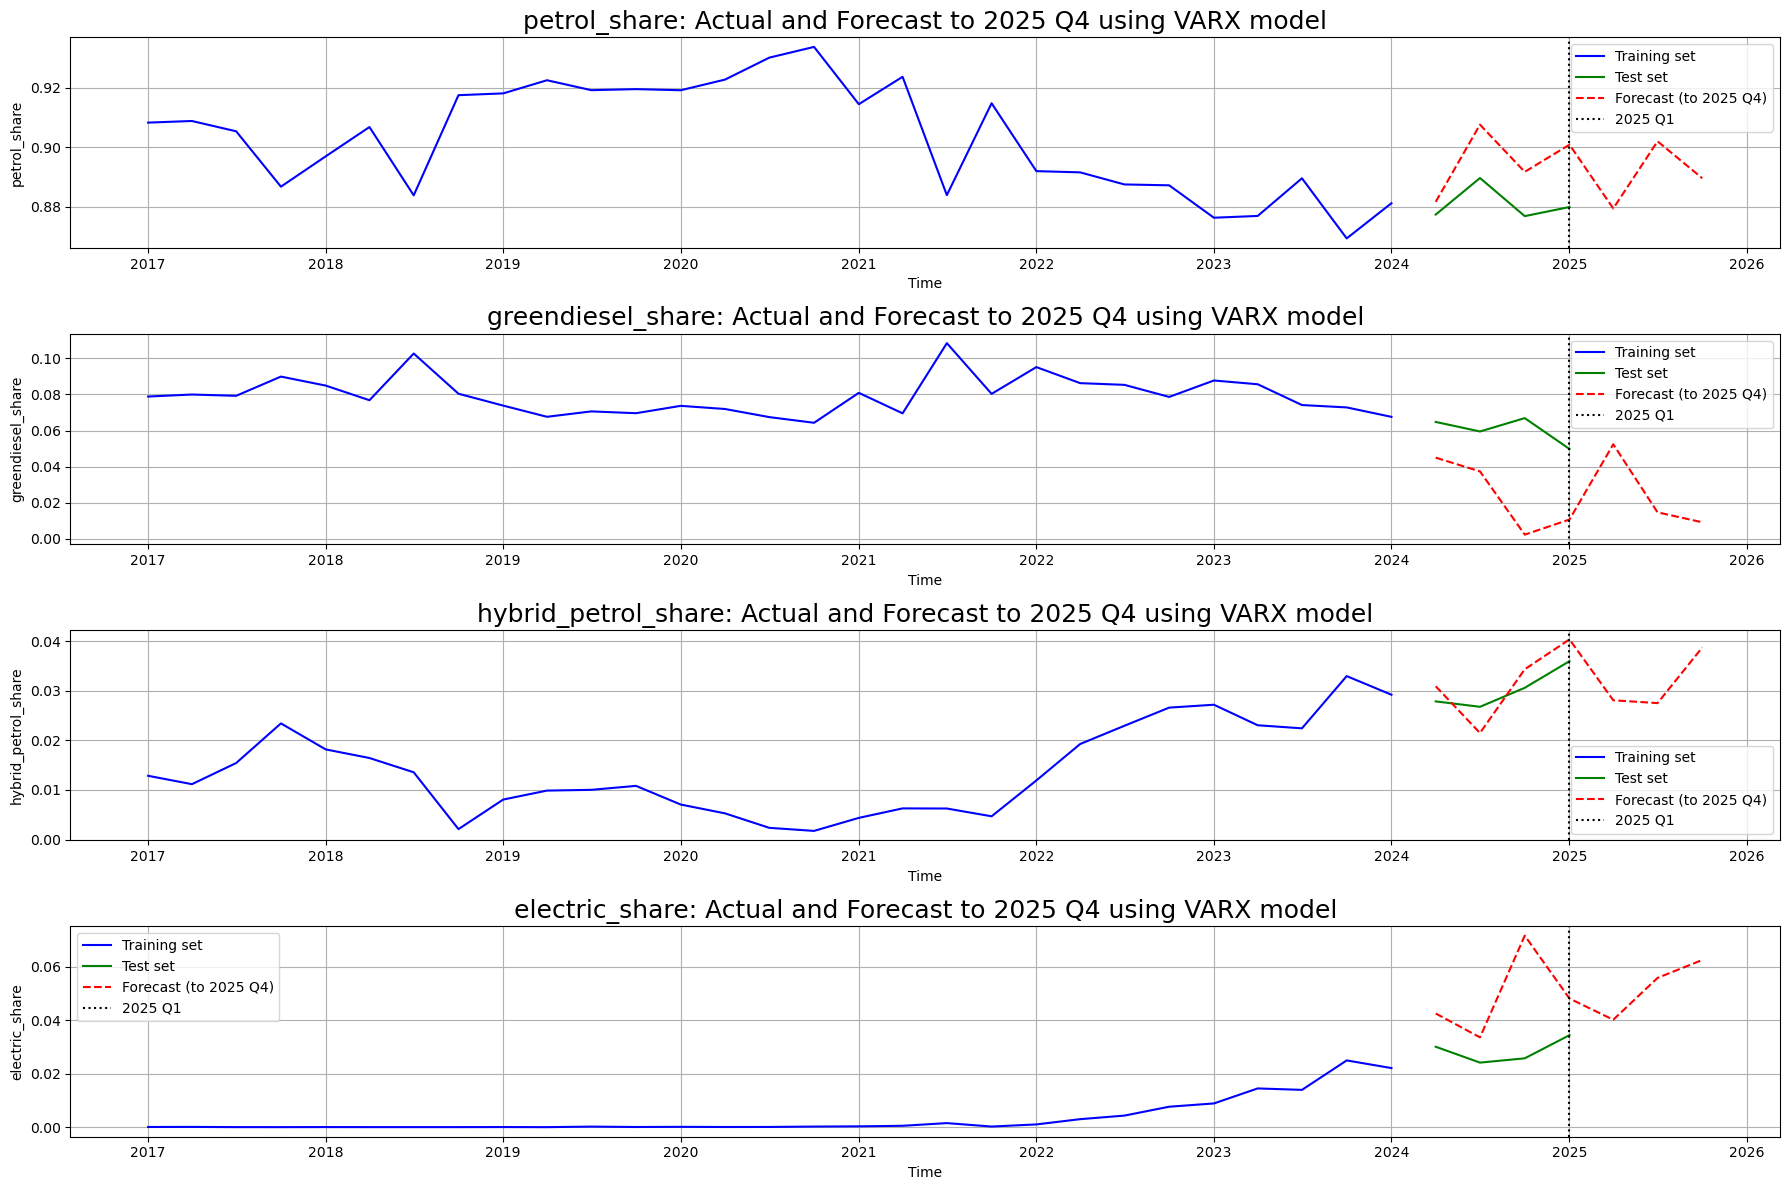

In [49]:
# Visualize the extended forecast
plt.figure(figsize=(18, 12))
for i, var in enumerate(endog_vars):
    plt.subplot(len(endog_vars), 1, i + 1)
    plt.plot(df_train.index, df_train[var], label='Training set', color='blue')
    plt.plot(df_test.index, df_test[var], label='Test set', color='green')
    plt.plot(df_full_forecast.index, df_full_forecast[var], label='Forecast (to 2025 Q4)', color='red', linestyle='--')
    plt.axvline(x=pd.to_datetime('2025-01-01'), color='black', linestyle=':', label='2025 Q1')
    plt.title(f'{var}: Actual and Forecast to 2025 Q4 using VARX model', fontsize=18)
    plt.xlabel('Time')
    plt.ylabel(var)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

### Vector Error Correction Model, VECM Model

In [50]:
# Load the dataset
df_model = pd.read_csv('Data/data_merged_modeling.csv')

# Conversion time to standard form
df_model['date'] = df_model['time'].apply(
    lambda x: pd.to_datetime(f"{x.split(' ')[0]}-{ {1:1, 2:4, 3:7, 4:10}[int(x.split(' ')[1][1])]}-01")
)
df_model = df_model.set_index('date').asfreq('QS')
df_model.tail()

,time,year,quarter,petrol,greendiesel,hybrid_petrol,electric,total,petrol_share,greendiesel_share,hybrid_petrol_share,electric_share,ron95,ron97,diesel,diesel_eastmsia,electric_price,policy
date,,,,,,,,,,,,,,,,,,
2024-01-01,2024 Q1,2024,Q1,186967,14340,6192,4689,212188,0.881138,0.067582,0.029182,0.022098,2.05,3.47,2.15,2.15,45.62,1
2024-04-01,2024 Q2,2024,Q2,174267,12865,5530,5974,198636,0.877318,0.064767,0.027840,0.030075,2.05,3.47,2.49,2.15,45.62,1
2024-07-01,2024 Q3,2024,Q3,190533,12741,5729,5171,214174,0.889618,0.059489,0.026749,0.024144,2.05,3.40,3.21,2.15,45.62,1
2024-10-01,2024 Q4,2024,Q4,202793,15470,7072,5955,231290,0.876791,0.066886,0.030576,0.025747,2.05,3.20,2.95,2.15,45.62,1
2025-01-01,2025 Q1,2025,Q1,174541,9877,7130,6827,198375,0.879854,0.049790,0.035942,0.034415,2.05,3.37,3.11,2.15,45.62,1


In [51]:
# Define endogenous and exogenous variables
endog_vars = ['petrol_share','hybrid_petrol_share',  'electric_share']
exog_vars = ['ron95', 'electric_price', 'policy']

# Set the proportion of data to use for training and testing
n_total = len(df_model)
n_train = int(n_total * 0.9)
n_test = n_total - n_train

# Extract training and testing datasets
df_train = df_model.iloc[:n_train]
df_test = df_model.iloc[n_train:]

# Display the lengths of the datasets
print(f"The length of the total dataset: {n_total}")
print(f"The length of the training dataset: {n_train}")
print(f"The length of the testing dataset: {n_test}")

The length of the total dataset: 33
The length of the training dataset: 29
The length of the testing dataset: 4


In [52]:
# Choose the cointegration rank using Johansen test
coint_rank_test = select_coint_rank(df_train[endog_vars], det_order=0, k_ar_diff=2, signif=0.05)
print(coint_rank_test.summary())
coint_rank = coint_rank_test.rank
print(f"Cointegration rank recommended based on Johansen test: {coint_rank}")


Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          30.89          29.80
  1   3          8.789          15.49
-------------------------------------
Cointegration rank recommended based on Johansen test: 1


In [53]:
# Selecting the VECM lag order
best_k_ar_diff = 1

# Fit the VECM model with the selected cointegration rank and lag order
model_vecm_fitted = VECM(
    df_train[endog_vars],
    exog=df_train[exog_vars],
    coint_rank=coint_rank,
    k_ar_diff=best_k_ar_diff,
    deterministic='ci_t'
).fit()
print(model_vecm_fitted.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation petrol_share
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
exog1                     -0.0186      0.013     -1.473      0.141      -0.043       0.006
exog2                      0.0011      0.001      1.627      0.104      -0.000       0.002
exog3                     -0.0103      0.005     -2.113      0.035      -0.020      -0.001
L1.petrol_share           -0.8947      0.136     -6.593      0.000      -1.161      -0.629
L1.hybrid_petrol_share    -1.7948      0.472     -3.799      0.000      -2.721      -0.869
L1.electric_share          1.4311      1.475      0.970      0.332      -1.460       4.322
Det. terms outside the coint. relation & lagged endog. parameters for equation hybrid_petrol_share
                             coef    std err          z      P>|z|      [0.025   

In [ ]:
# Set test data for forecasting
exog_forecast = df_test[exog_vars].values
n_forecast_steps = len(df_test)

# Use the fitted model to forecast values
forecast_output = model_vecm_fitted.predict(
    steps=n_forecast_steps,
    exog_fc=exog_forecast
)
df_forecast = pd.DataFrame(forecast_output, index=df_test.index, columns=endog_vars)
df_forecast

,petrol_share,hybrid_petrol_share,electric_share
date,,,
2024-04-01,0.872604,0.033938,0.040049
2024-07-01,0.895780,0.027691,0.033595
2024-10-01,0.875842,0.036640,0.063250
2025-01-01,0.917161,0.025161,0.049836


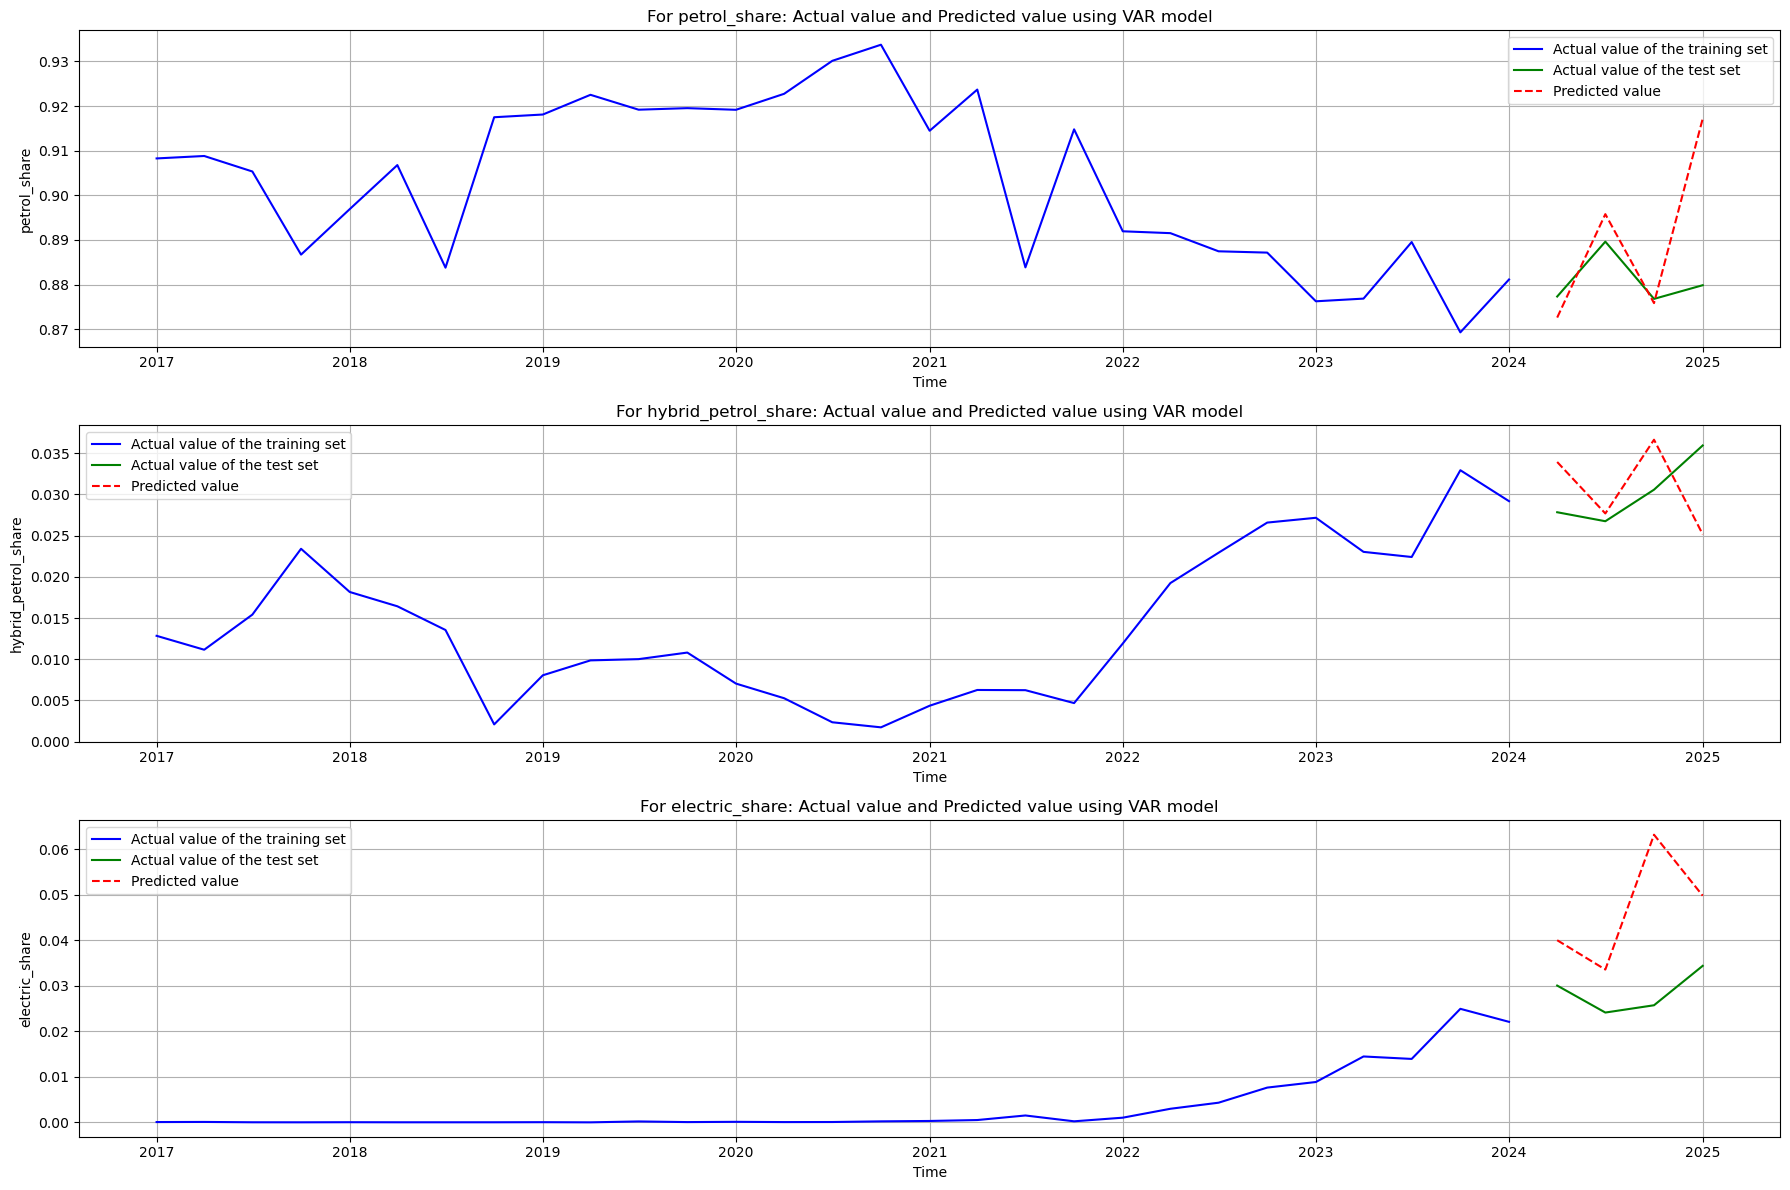

In [ ]:
# Visualize the actual values and forecasted values
plt.figure(figsize=(18, 12))
for i, var in enumerate(endog_vars):
    plt.subplot(len(endog_vars), 1, i + 1)
    plt.plot(df_train.index, df_train[var], label='Actual value of the training set', color='blue')
    plt.plot(df_test.index, df_test[var], label='Actual value of the test set', color='green')
    plt.plot(df_forecast.index, df_forecast[var], label='Predicted value', color='red', linestyle='--')
    plt.title(f'For {var}: Actual value and Predicted value using VECM model')
    plt.xlabel('Time')
    plt.ylabel(var)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
# Save evaluation results
evaluation_results = []

# Evaluate the model using RMSE and MAE
for var in endog_vars:
    actual = df_test[var]
    predicted = df_forecast[var]
    rmse_val = rmse(actual, predicted)
    mae_val = meanabs(actual, predicted)
    evaluation_results.append({
        'variable': var,
        'RMSE': rmse_val,
        'MAE': mae_val
    })

# Convert evaluation results to DataFrame
df_model_evaluation = pd.DataFrame(evaluation_results)
df_model_evaluation.to_csv('Data/data_model_VECM_evaluation_results.csv', index=False)
df_model_evaluation

,variable,RMSE,MAE
0,petrol_share,0.019058,0.012283
1,hybrid_petrol_share,0.006912,0.005971
2,electric_share,0.021407,0.018087


In [57]:
# Calculate residuals from the fitted model
n_resid = model_vecm_fitted.resid.shape[0]
index_residuals = df_model.index[-n_resid:]
df_residuals = pd.DataFrame(model_vecm_fitted.resid, index=index_residuals, columns=endog_vars)
df_residuals


,petrol_share,hybrid_petrol_share,electric_share
date,,,
2018-07-01,-0.008477,0.005134,0.000189
2018-10-01,-0.013376,0.006580,-0.000604
2019-01-01,0.008204,-0.005277,-0.001472
2019-04-01,0.009071,-0.001982,-0.000443
2019-07-01,-0.017751,-0.004258,-0.000438
2019-10-01,0.007453,-0.006576,0.000244
2020-01-01,0.006369,0.004854,0.001483
2020-04-01,0.012787,0.000193,0.000202
2020-07-01,0.001084,-0.000761,0.000369


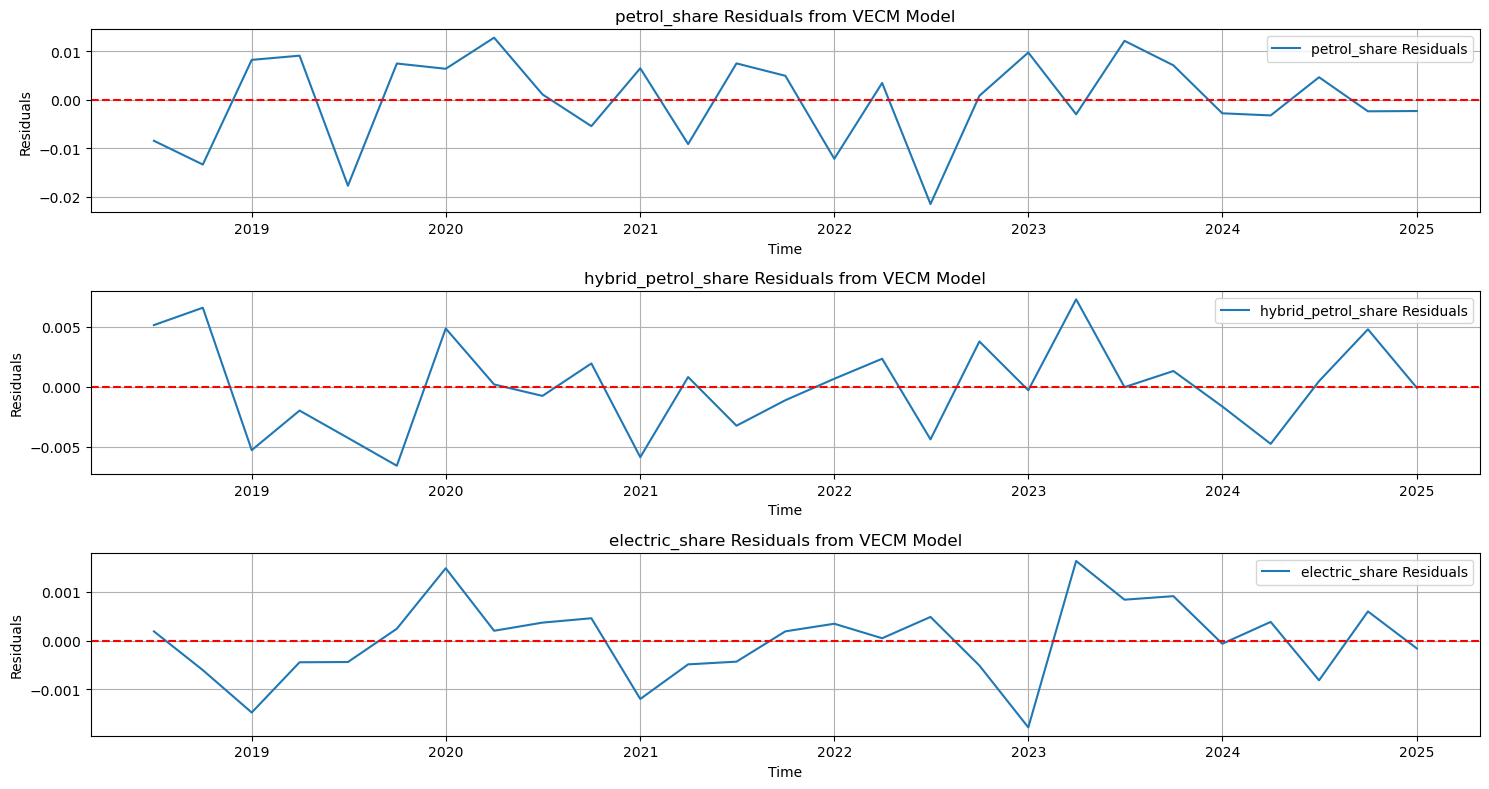

In [58]:
# Visualize the residuals of the fitted model
plt.figure(figsize=(15, 8))
for i, var in enumerate(endog_vars):
    plt.subplot(len(endog_vars), 1, i + 1)
    plt.plot(df_residuals.index, df_residuals[var], label=f'{var} Residuals')
    plt.title(f'{var} Residuals from VECM Model')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
# Auto-correlation and Ljung-Box test for residuals
for var in endog_vars:
    lb_test = acorr_ljungbox(df_residuals[var], lags=[4, 8, 12], return_df=True)
    print(f"{var} Residuals Auto-correlation and Ljung-Box Test Results:")
    print(lb_test)

petrol_share Residuals Auto-correlation and Ljung-Box Test Results:
      lb_stat  lb_pvalue
4    4.405894   0.353852
8    7.155365   0.519967
12  11.288905   0.504335
hybrid_petrol_share Residuals Auto-correlation and Ljung-Box Test Results:
      lb_stat  lb_pvalue
4    4.538662   0.337988
8    8.525977   0.383846
12  11.600666   0.478260
electric_share Residuals Auto-correlation and Ljung-Box Test Results:
      lb_stat  lb_pvalue
4    4.900860   0.297622
8    8.826143   0.357174
12  10.598140   0.563635


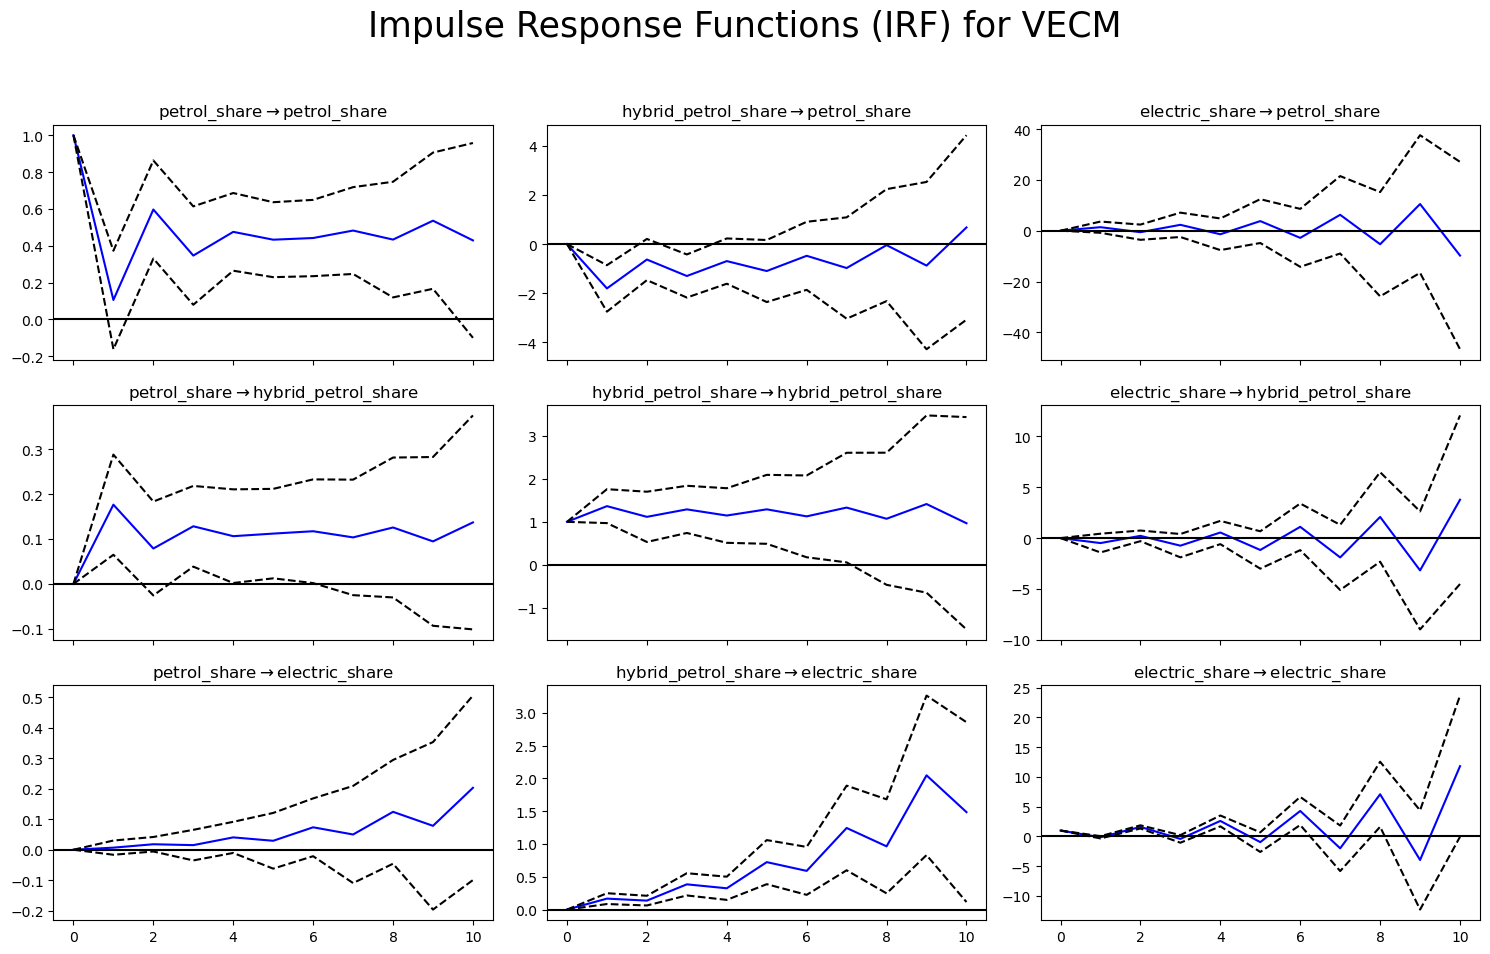

In [60]:
# Visualize the autocorrelation of residuals
irf = model_vecm_fitted.irf(periods=10)
irf.plot(orth=False, figsize=(15, 10))
plt.suptitle('Impulse Response Functions (IRF) for VECM', fontsize=25)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [61]:
# Extended forecast to 2025 Q4
forecast_dates = pd.date_range(start='2025-04-01', end='2025-10-01', freq='QS')
n_extended_steps = len(forecast_dates)

# Fill future exog with last quarter's exog value (conservative estimate)
last_exog = df_test[exog_vars].iloc[-1].values
future_exog = np.tile(last_exog, (n_extended_steps, 1))

# Create a full exogenous forecast array
full_exog_forecast = np.vstack([df_test[exog_vars].values, future_exog])
full_forecast_steps = len(full_exog_forecast)

# Perform predictions using fitted VECM model
forecast_output_extended = model_vecm_fitted.predict(
    steps=full_forecast_steps,
    exog_fc=full_exog_forecast
)

# Generate prediction DataFrame
extended_index = df_test.index.union(forecast_dates)
df_full_forecast = pd.DataFrame(forecast_output_extended, index=extended_index, columns=endog_vars)
df_full_forecast.to_csv('Data/data_model_VECM_full_forecast.csv', index=True)
df_full_forecast

,petrol_share,hybrid_petrol_share,electric_share
2024-04-01,0.872604,0.033938,0.040049
2024-07-01,0.895780,0.027691,0.033595
2024-10-01,0.875842,0.036640,0.063250
2025-01-01,0.917161,0.025161,0.049836
2025-04-01,0.879580,0.040900,0.099042
2025-07-01,0.950490,0.020590,0.072438
2025-10-01,0.882250,0.048013,0.154501


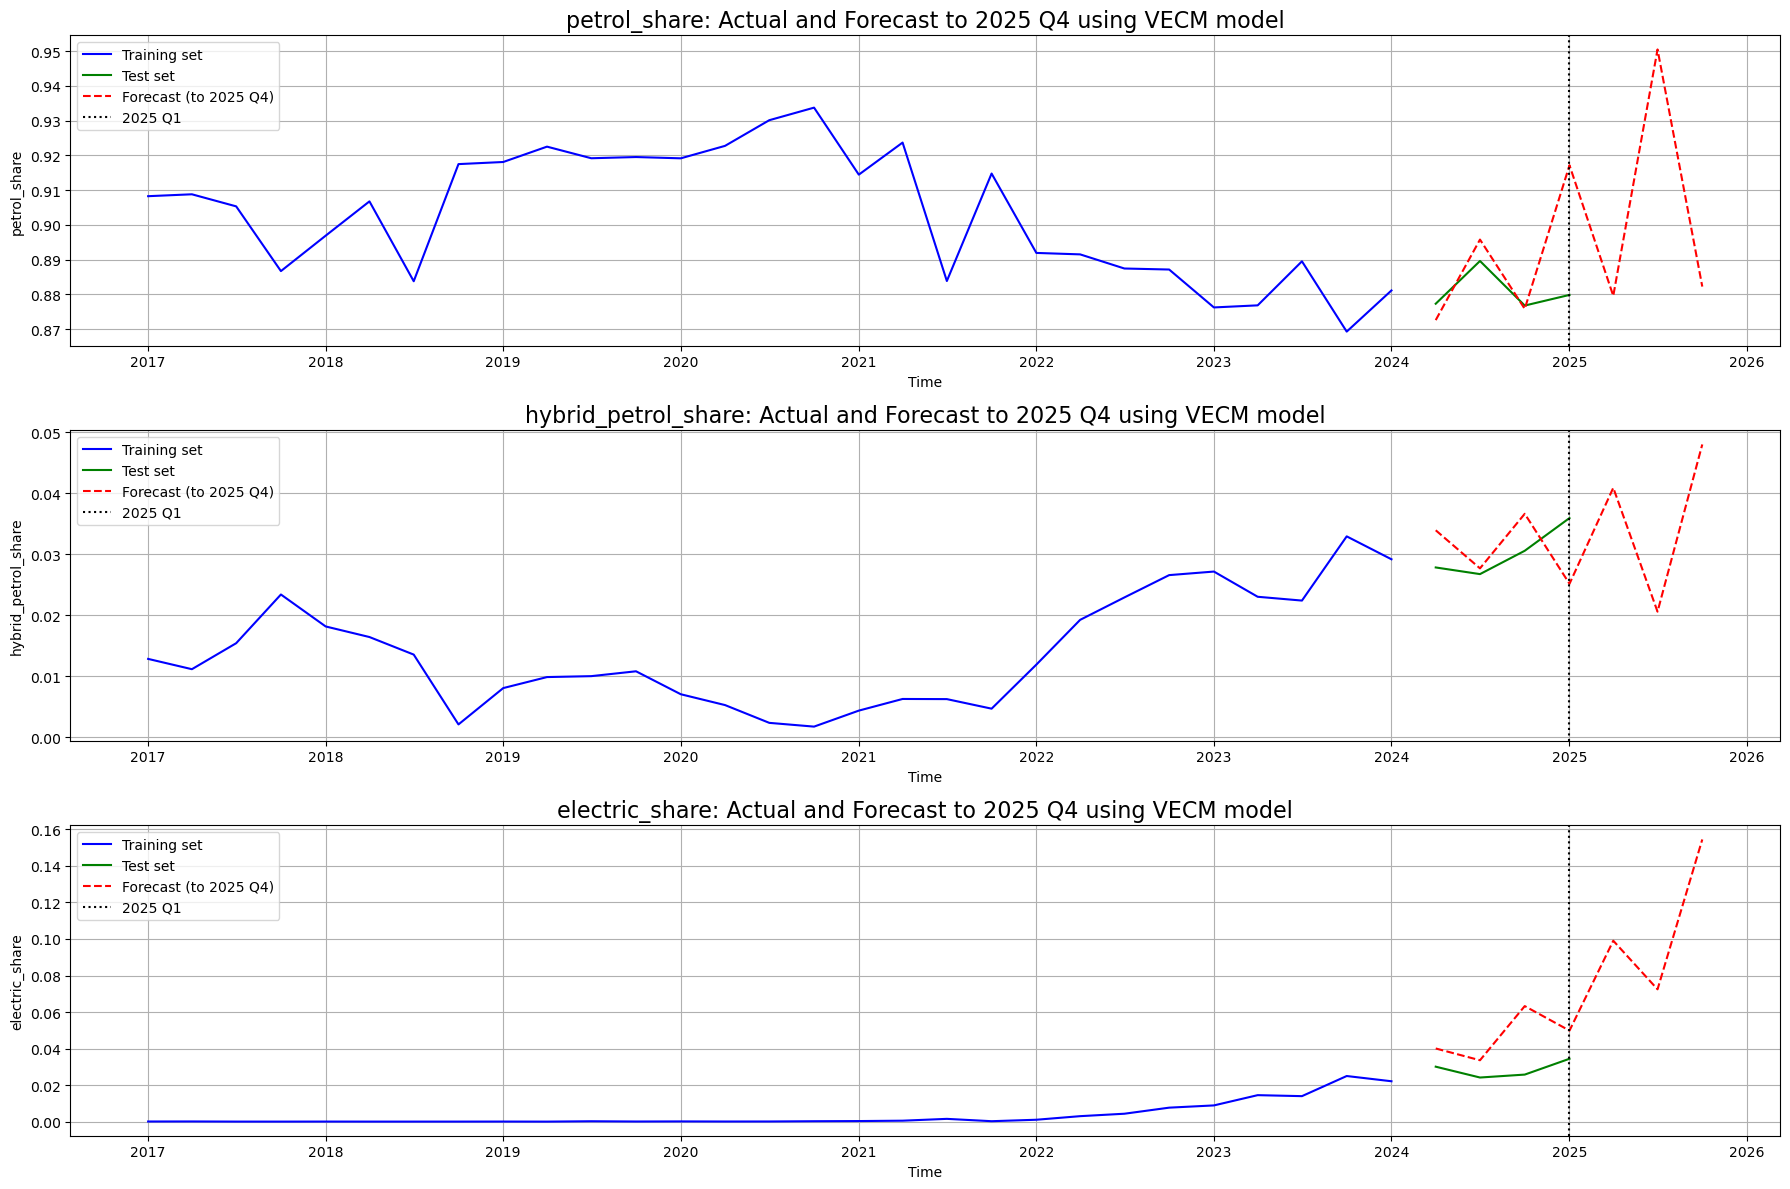

In [62]:
# Visualize the extended forecast
plt.figure(figsize=(18, 12))
for i, var in enumerate(endog_vars):
    plt.subplot(len(endog_vars), 1, i + 1)
    plt.plot(df_train.index, df_train[var], label='Training set', color='blue')
    plt.plot(df_test.index, df_test[var], label='Test set', color='green')
    plt.plot(df_full_forecast.index, df_full_forecast[var], label='Forecast (to 2025 Q4)', color='red', linestyle='--')
    plt.axvline(x=pd.to_datetime('2025-01-01'), color='black', linestyle=':', label='2025 Q1')
    plt.title(f'{var}: Actual and Forecast to 2025 Q4 using VECM model', fontsize=16)
    plt.xlabel('Time')
    plt.ylabel(var)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()